In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
noncat = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

train[noncat+['Calories']].corr()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
Age,1.000000,0.011975,0.073690,0.015656,0.017037,0.030275,0.145683
Height,0.011975,1.000000,0.957967,-0.029936,-0.013234,-0.034641,-0.004026
Weight,0.073690,0.957967,1.000000,-0.020845,-0.002384,-0.023717,0.015863
Duration,0.015656,-0.029936,-0.020845,1.000000,0.875327,0.903066,0.959908
Heart_Rate,0.017037,-0.013234,-0.002384,0.875327,1.000000,0.795972,0.908748
Body_Temp,0.030275,-0.034641,-0.023717,0.903066,0.795972,1.000000,0.828671
Calories,0.145683,-0.004026,0.015863,0.959908,0.908748,0.828671,1.000000


In [ ]:
y = np.log1p(train['Calories'])

X = train.drop(columns=['id', 'Calories'])
X['Sex'] = X['Sex'].astype('category')

X['BMI'] = X['Weight']/((X['Height']/100)**2)
X['Intensity'] = X['Duration']*X['Heart_Rate']

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity
0,male,36,189.0,82.0,26.0,101.0,41.0,22.955684,2626.0
1,female,64,163.0,60.0,8.0,85.0,39.7,22.582709,680.0
2,female,51,161.0,64.0,7.0,84.0,39.8,24.690405,588.0
3,male,20,192.0,90.0,25.0,105.0,40.7,24.414062,2625.0
4,female,38,166.0,61.0,25.0,102.0,40.6,22.136740,2550.0


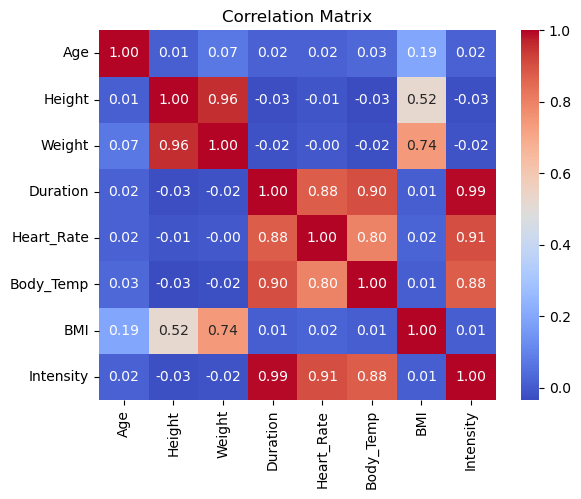

In [8]:
noncat = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Intensity']



sns.heatmap(X[noncat].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [21]:
number_leaves = [256,512,1024]
learning_rate = [0.25,0.2,0.1,0.05]
number_boosts = [100,150,200]

model_err = {}

for nl in number_leaves:
    for lr in learning_rate:
        for nbr in number_boosts:

            # Initialize KFold
            kf = KFold(n_splits=5, shuffle=True)

            # Initialize a list to collect accuracy scores
            scores = []

            # Iterate over each fold
            for train_index, test_index in kf.split(X):

                X_train, X_test = X.loc[train_index], X.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]

                dtrain = lgb.Dataset(X_train, label=y_train)

                
                # Define parameters
                params = {
                    'num_leaves': nl,
                    'learning_rate': lr,
                    'objective': 'regression',  # same as rmse
                    'metric': 'rmse',           # 
                    'force_col_wise': True,     # Optional: can help with categorical support
                    'subsample': 0.8,
                    'verbose': -1
                }

                # Initialize and train the model
                model = lgb.train(params, dtrain, num_boost_round=nbr)


                # Predict and evaluate the model
                y_pred = model.predict(X_test)
                y_pred[y_pred <= 0] = 10
                score = rmse(y_test, y_pred)
                scores.append(score)

            
            # Output the mean accuracy over all folds
            print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}: {np.mean(scores)}")

            model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=256, learn_rate=0.25, num_boost=100: 0.061596489538638534
Mean Accuracy for num_leaves=256, learn_rate=0.25, num_boost=150: 0.06180794311239152
Mean Accuracy for num_leaves=256, learn_rate=0.25, num_boost=200: 0.06190768682672426
Mean Accuracy for num_leaves=256, learn_rate=0.2, num_boost=100: 0.061085373593917434
Mean Accuracy for num_leaves=256, learn_rate=0.2, num_boost=150: 0.06132099044223362
Mean Accuracy for num_leaves=256, learn_rate=0.2, num_boost=200: 0.061264047964379544
Mean Accuracy for num_leaves=256, learn_rate=0.1, num_boost=100: 0.060435540423495734
Mean Accuracy for num_leaves=256, learn_rate=0.1, num_boost=150: 0.060528929008106414
Mean Accuracy for num_leaves=256, learn_rate=0.1, num_boost=200: 0.060442737923685305
Mean Accuracy for num_leaves=256, learn_rate=0.05, num_boost=100: 0.06099506112447288
Mean Accuracy for num_leaves=256, learn_rate=0.05, num_boost=150: 0.06021031377361515
Mean Accuracy for num_leaves=256, learn_rate=0.05, num

In [4]:
number_leaves = [200,210,220,230,240,250,260,270]
learning_rate = [0.04, 0.05, 0.06]
number_boosts = [100,150,200,250,300,350,400]

model_err = {}

for nl in number_leaves:
    for lr in learning_rate:
        for nbr in number_boosts:

            # Initialize KFold
            kf = KFold(n_splits=5, shuffle=True)

            # Initialize a list to collect accuracy scores
            scores = []

            # Iterate over each fold
            for train_index, test_index in kf.split(X):

                X_train, X_test = X.loc[train_index], X.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]

                dtrain = lgb.Dataset(X_train, label=y_train)

                
                # Define parameters
                params = {
                    'num_leaves': nl,
                    'learning_rate': lr,
                    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
                    'metric': 'rmse',           # 
                    'force_col_wise': True,     # Optional: can help with categorical support
                    'subsample': 0.75,
                    'verbose': -1
                }

                # Initialize and train the model
                model = lgb.train(params, dtrain, num_boost_round=nbr)


                # Predict and evaluate the model
                y_pred = model.predict(X_test)
                y_pred[y_pred <= 0] = 10
                score = rmse(y_test, y_pred)
                scores.append(score)

            
            # Output the mean accuracy over all folds
            print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}: {np.mean(scores)}")

            model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=100: 0.0638981815531489
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=150: 0.06060902890027224
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=200: 0.06021117675411706
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=250: 0.06023604325360717
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=300: 0.060188789613580776
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=350: 0.06016261586972419
Mean Accuracy for num_leaves=200, learn_rate=0.04, num_boost=400: 0.060076846606816406
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=100: 0.06105615288958729
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=150: 0.060268192009832425
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=200: 0.060205366893642843
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=250: 0.06018756067676702
Mean Accuracy for num_leaves=200, learn_rate=0.05, 

In [7]:
number_leaves = [150,200,250]
learning_rate = [0.05]
number_boosts = [100,150,200,250,300,350]

model_err = {}

for nl in number_leaves:
    for lr in learning_rate:
        for nbr in number_boosts:

            # Initialize KFold
            kf = KFold(n_splits=5, shuffle=True)

            # Initialize a list to collect accuracy scores
            scores = []

            # Iterate over each fold
            for train_index, test_index in kf.split(X):

                X_train, X_test = X.loc[train_index], X.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]

                dtrain = lgb.Dataset(X_train, label=y_train)

                
                # Define parameters
                params = {
                    'num_leaves': nl,
                    'learning_rate': lr,
                    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
                    'metric': 'rmse',           # 
                    'force_col_wise': True,     # Optional: can help with categorical support
                    'subsample': 0.7,
                    'verbose': -1
                }

                # Initialize and train the model
                model = lgb.train(params, dtrain, num_boost_round=nbr)


                # Predict and evaluate the model
                y_pred = model.predict(X_test)
                y_pred[y_pred <= 0] = 10
                score = rmse(y_test, y_pred)
                scores.append(score)

            
            # Output the mean accuracy over all folds
            print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}: {np.mean(scores)}")

            model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=150, learn_rate=0.05, num_boost=100: 0.06140541680720063
Mean Accuracy for num_leaves=150, learn_rate=0.05, num_boost=150: 0.06045141430166993
Mean Accuracy for num_leaves=150, learn_rate=0.05, num_boost=200: 0.06036611063780907
Mean Accuracy for num_leaves=150, learn_rate=0.05, num_boost=250: 0.06021409524518399
Mean Accuracy for num_leaves=150, learn_rate=0.05, num_boost=300: 0.060336994779463735
Mean Accuracy for num_leaves=150, learn_rate=0.05, num_boost=350: 0.06022685774296137
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=100: 0.06126443246888643
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=150: 0.060337851583379364
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=200: 0.060172643408238434
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=250: 0.060222146285837684
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=300: 0.060223195391555996
Mean Accuracy for num_leaves=200, learn_rate=0.05

In [5]:
X_train = train.sample(n=600000, random_state=212)
y_train = np.log1p(X_train['Calories'])

X_train.drop(columns=['id', 'Calories'], inplace=True)
X_train['Sex'] = X_train['Sex'].astype('category')

X_train['BMI'] = X_train['Weight']/((X_train['Height']/100)**2)
X_train['Intensity'] = X_train['Duration']*X_train['Heart_Rate']

X_train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity
637285,male,40,182.0,85.0,16.0,91.0,40.2,25.661152,1456.0
137087,female,30,158.0,64.0,10.0,90.0,40.2,25.636917,900.0
11662,male,54,184.0,87.0,3.0,82.0,38.8,25.697070,246.0
83022,female,61,186.0,81.0,25.0,106.0,40.7,23.413111,2650.0
405249,female,40,169.0,69.0,11.0,99.0,39.9,24.158818,1089.0


In [ ]:
# Kaggle score 0.05799, lgb_prediction_12.csv

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'num_leaves': 240,
    'learning_rate': 0.04,
    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
    'metric': 'rmse',           # We'll manually compute RMSLE
    'force_col_wise': True,     # Optional: can help with categorical support
    'subsample': 0.75
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=250)

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
# test_pred[test_pred < 0] = 10

print(rmse(test_pred, y_train))

0.054873148928761405


In [ ]:
# Kaggle score 0.05803

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'num_leaves': 256,
    'learning_rate': 0.05,
    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
    'metric': 'rmse',           # 
    'force_col_wise': True,     # Optional: can help with categorical support
    'subsample': 0.8
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=200)

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
# test_pred[test_pred < 0] = 10

print(rmse(test_pred, y_train))

0.054628630637387814


In [ ]:
# Kaggle score 0.05837

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'num_leaves': 150,
    'learning_rate': 0.05,
    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
    'metric': 'rmse',           # 
    'force_col_wise': True,     # Optional: can help with categorical support
    'subsample': 0.75
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=300)

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
# test_pred[test_pred < 0] = 10

print(rmse(test_pred, y_train))

0.0554637257060297


In [7]:
test.drop(columns=['id'], inplace=True)

test['Sex'] = test['Sex'].astype('category')

test['BMI'] = test['Weight']/((test['Height']/100)**2)
test['Intensity'] = test['Duration']*test['Heart_Rate']

test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity
0,male,45,177.0,81.0,7.0,87.0,39.8,25.854639,609.0
1,male,26,200.0,97.0,20.0,101.0,40.5,24.250000,2020.0
2,female,29,188.0,85.0,16.0,102.0,40.4,24.049344,1632.0
3,female,39,172.0,73.0,20.0,107.0,40.6,24.675500,2140.0
4,female,30,173.0,67.0,16.0,94.0,40.5,22.386314,1504.0


In [8]:
# make the submission file!

pred = model.predict(test)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 10

submission.to_csv("lgb_prediction_12.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   26.995613
1  750001  109.267075
2  750002   86.661870
3  750003  127.797312
4  750004   75.283527

count    250000.000000
mean         88.175709
std          62.270934
min           0.908306
25%          34.044122
50%          76.446632
75%         135.448630
max         289.945549
Name: Calories, dtype: float64
